In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-sign-dataset-classification/labels.csv
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_1_0060.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_1_0073.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_1_0045.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_1_0020.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_0012.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_0061.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_1_0074.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_1_0034.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_0053.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_1_0047.png
/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/7/007_0023.png
/kaggle/inpu

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling, Conv2D
from tensorflow.keras.layers import Input,Dense,Layer,LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Loading the dataset 

In [6]:
train_dataset_path = '/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA'
# Loading the train dataset
train_dataset = image_dataset_from_directory(
    train_dataset_path, 
    image_size = (224,224),
    batch_size = 8,
    label_mode = 'categorical',
    validation_split = 0.1,
    subset = 'training',
    seed = 111
)
# Loading the validation dataset
val_dataset = image_dataset_from_directory(
    train_dataset_path, 
    image_size = (224,224),
    batch_size = 8,
    label_mode = 'categorical',
    validation_split = 0.1,
    subset = 'validation',
    seed = 111
)

Found 4170 files belonging to 58 classes.
Using 3753 files for training.
Found 4170 files belonging to 58 classes.
Using 417 files for validation.


In [7]:
# Assigning the class name
class_names = train_dataset.class_names
# Displaying the class name
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']


In [8]:
# Auto fetching the dataset 
AUTOTUNE = tf.data.AUTOTUNE

# Pre loading the dataset for training 
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Normalizing the images

In [9]:
# Normalize 
normalize_image = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x,y: (normalize_image(x), y))
val_dataset = val_dataset.map(lambda x,y: (normalize_image(x), y))

# Displaying the Images

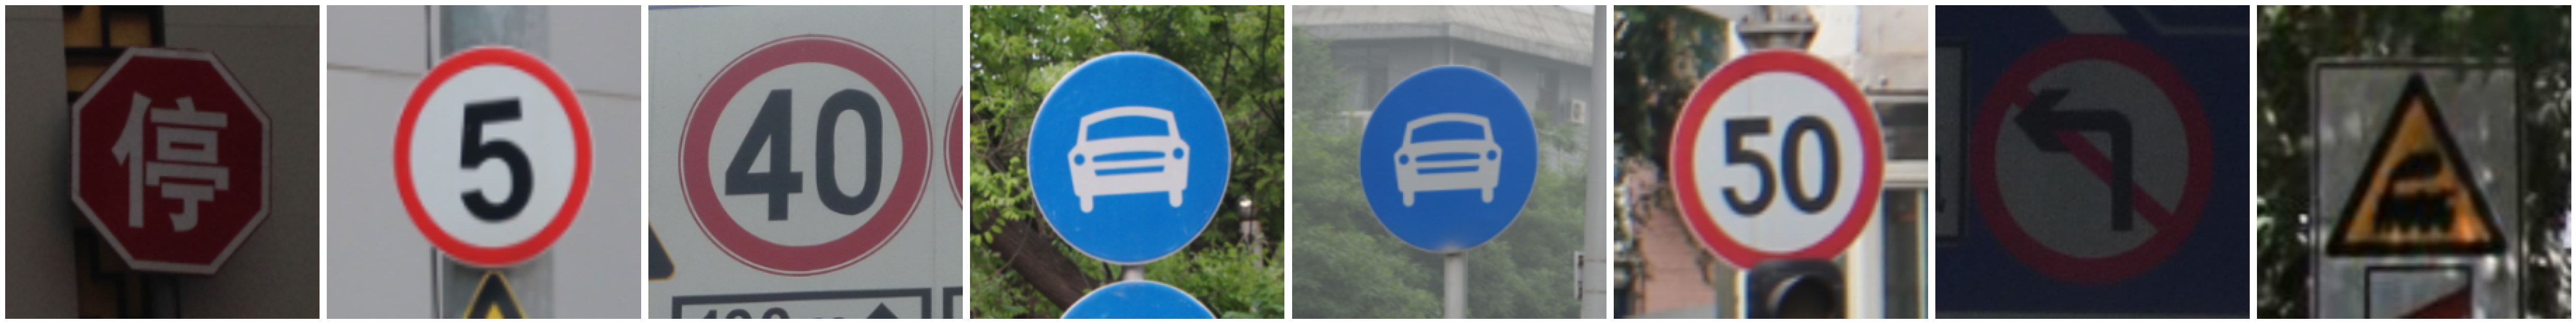

In [10]:
# Defining the function for displaying the image
def display_image(image):
    fig, axes = plt.subplots(1,8, figsize = (50,50))
    axes = axes.flatten()
    for img, ax in zip(image,axes):
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Calling the function 
image , label = next(iter(train_dataset))
display_image(image)

In [11]:
# Checking the shape of dataset
for img, lbl in train_dataset.take(1):  # Take one batch for checking
    print("Image Shape:", img.shape)  
    print("Label Shape:", lbl.shape)

Image Shape: (8, 224, 224, 3)
Label Shape: (8, 58)


# Convert Image into patches(Pixel Embedding)

In [13]:
class PatchEmbedding(Layer):
    # Constructor
    def __init__(self, patch_size = 16, embedding_dim = 768):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.projection = Conv2D(
            filters = embedding_dim,
            kernel_size = patch_size,
            strides = patch_size,
            padding = 'valid'
        )

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height, width = tf.shape(images)[1] , tf.shape(images)[2]
        total_number_of_patches = tf.math.floordiv(height, self.patch_size) * tf.math.floordiv(width, self.patch_size)

        patches = self.projection(images)
        patches = tf.reshape(patches, [-1, total_number_of_patches, self.embedding_dim])
        return patches

# Transformer Block

In [14]:
# Defining the Transformer block
class TransformerBlock(Layer):
    def __init__(self, embedding_dim = 768, num_heads = 12, mlp_dim = 3072):
        super().__init__()
        self.normalizelayer1 = LayerNormalization()
        self.attention = MultiHeadAttention(num_heads = num_heads, key_dim = embedding_dim)
        self.normalizelayer2 = LayerNormalization()
        self.mlp = Sequential([
            Dense(mlp_dim, activation = 'gelu'),
            Dense(embedding_dim)
        ])

    def call(self, inputs):
        x = self.normalizelayer1(inputs)
        x = self.attention(x,x)
        x = x + inputs # skip connection
        
        y = self.normalizelayer2(x)
        y = self.mlp(y) 
        return x + y

# Special Token (CLS)

In [15]:
# Define the class that Adding special Token(CLS)
class AddCLSToken(Layer):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.cls_token = self.add_weight(
            shape=(1, 1, embedding_dim), 
            initializer="random_normal", 
            trainable=True
        )
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_token = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embedding_dim]) # Matching the shape with pixel embedding
        return tf.concat([cls_token, inputs], axis=1)


# Position Encoding Layer

In [16]:
class PositionEncodingLayer(Layer):
    def __init__(self, embedding_dim):
        super().__init__()
        self.embedding_dim = embedding_dim 
        
    def call(self, x):
        shape = tf.shape(x)
        position_encoding = tf.random.normal((shape[0], shape[1], self.embedding_dim))
        return x + position_encoding

# Building the model

In [17]:
# Building the classifier model
def build(img_size = 224, patch_size = 16, num_classes = 58, num_layer = 12, embedding_dim = 768):
    # Input layer 
    input_layer = Input(shape = (img_size,img_size,3))
    
    # Pixel Embedding 
    x = PatchEmbedding(patch_size, embedding_dim)(input_layer)

    # Class token(Adding special token: CLS)
    # cls_token = tf.Variable(tf.random.normal([1,1,embedding_dim]), trainable = True)
    
    # # Defining the method for adding special token
    # def add_cls(inputs):
    #     batch_size = tf.shape(inputs)[0]
    #     cls_token = tf.broadcast_to(cls_token, [batch_size, 1, embedding_dim]) # Matching the shape with pixel embedding
    #     x = tf.concat([cls_token, x], axis = 1) # adding the special token in pixel embedding
    # # Call the method with the help of lambda
    # x = Lambda(add_cls, output_shape=(None, embedding_dim))(x)
    x = AddCLSToken(embedding_dim)(x)
    
    # Tracking the position of patch(Adding the position token)
    # position_encoding = tf.Variable(tf.random.normal([1, tf.shape(x)[1], embedding_dim]), trainable = True)
    # x += position_encoding
    x = PositionEncodingLayer(embedding_dim)(x)

    # Transformer Block
    for _ in range(num_layer):
        x = TransformerBlock(embedding_dim)(x)

    # Classication Head
    x = LayerNormalization()(x[:,0,:])
    outputs_layer = Dense(num_classes, activation = 'softmax')(x)

    # Define model
    model = Model(input_layer,outputs_layer)

    return model

# Training the model

In [18]:
# Calling the build function 
vision_transformer_model = build(num_classes = len(class_names))

# Compiling the model 
vision_transformer_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate = 3e-5),
    metrics = ['accuracy']
    )
# Summary of the model 
vision_transformer_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding (PatchEmbedding)     │ (None, 196, 768)            │         590,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add_cls_token (AddCLSToken)          │ (None, 197, 768)            │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ position_encoding_layer              │ (None, 197, 768)            │               0 │
│ (PositionEncodingLayer)              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 197, 768)            │      33,065,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_5                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_6                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_7                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_8                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_9                  │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_10                 │ (None, 197, 768)            │      33,065,472 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_11                 │ (None, 197, 768)            │      33,065,4

 Total params: 397,423,162 (1.48 GB)

 Trainable params: 397,423,162 (1.48 GB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train 
history = vision_transformer_model.fit(train_dataset, epochs = 32, validation_data = val_dataset)

Epoch 1/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 368s 689ms/step - accuracy: 0.0748 - loss: 4.1662 - val_accuracy: 0.1966 - val_loss: 3.4432
Epoch 2/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 302s 642ms/step - accuracy: 0.1620 - loss: 3.2747 - val_accuracy: 0.2134 - val_loss: 3.0548
Epoch 3/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 302s 642ms/step - accuracy: 0.1974 - loss: 3.0773 - val_accuracy: 0.2806 - val_loss: 2.8300
Epoch 4/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 302s 642ms/step - accuracy: 0.2315 - loss: 2.9053 - val_accuracy: 0.2878 - val_loss: 2.7025
Epoch 5/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 302s 642ms/step - accuracy: 0.2689 - loss: 2.6269 - val_accuracy: 0.3118 - val_loss: 2.5595
Epoch 6/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 302s 642ms/step - accuracy: 0.3287 - loss: 2.3821 - val_accuracy: 0.2830 - val_loss: 2.3621
Epoch 7/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 302s 642ms/step - accuracy: 0.3496 - loss: 2.2335 - val_accuracy: 0.4029 - val_loss: 2.1789
Epoch 8/32
470/470 ━━━━━━━━━━━━━━━━━━━━ 302s 642ms/step - accuracy: 0.4010 -

In [ ]:
# Saving the model 
vision_transformer_model.save('traffic_sign_classification.keras')

# Evaluate the model

In [20]:
# Loading the labels classification name using pandas 
labels_name = pd.read_csv('/kaggle/input/traffic-sign-dataset-classification/labels.csv')

# Converting this into row wise
label = labels_name.to_dict(orient = 'records')

In [21]:
# Path of the test dataset
test_path = '/kaggle/input/traffic-sign-dataset-classification/traffic_Data/TEST'


# Loading the test dataset 
test_dataset = image_dataset_from_directory(
    test_path,
    image_size = (224,224),
    batch_size = 8,
    label_mode = None,
    shuffle=True
)

Found 1994 files.


In [22]:
# Normalize the test dataset
test_dataset = test_dataset.map(lambda x:(normalize_image(x)))

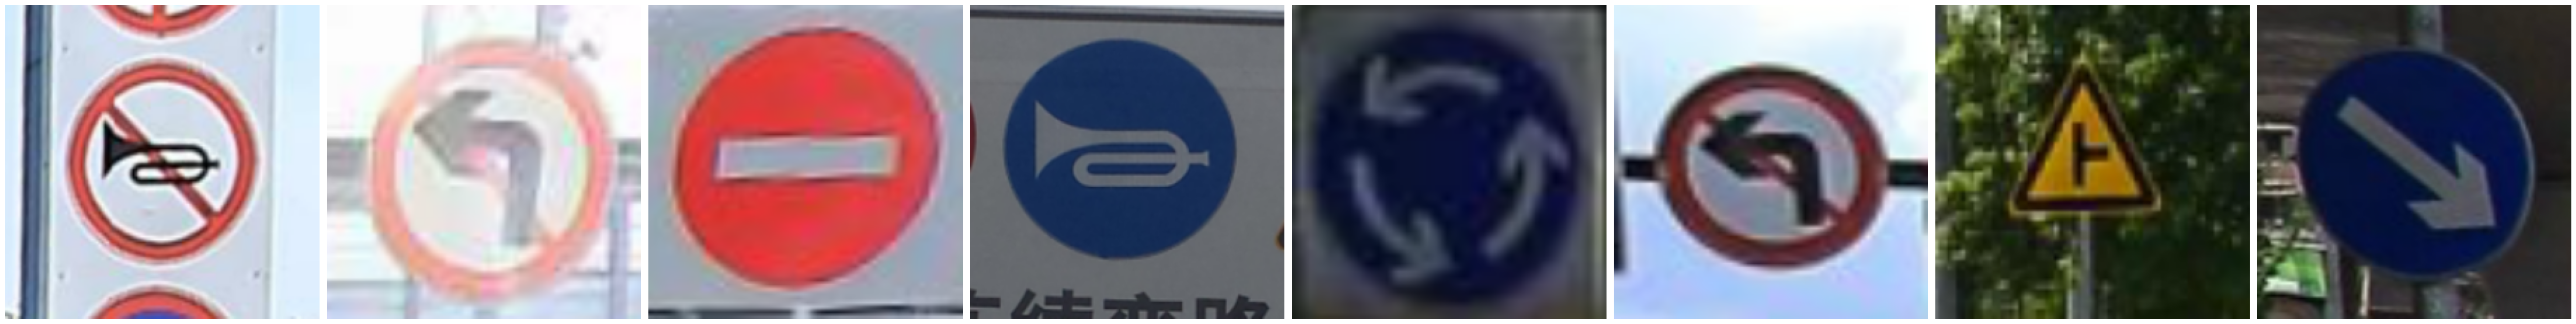

In [23]:
# Dispalying the test dataset
image = next(iter(test_dataset))
display_image(image)

In [24]:
# Convert the dataset to a list of batches
test_image_list = list(test_dataset.as_numpy_iterator())

# Flatten the list 
test_images = np.concatenate(test_image_list, axis = 0)

In [25]:
# Selecting the random image 
random_index = random.randint(0,len(test_images)-1)
random_image = test_images[random_index]

In [26]:
# Defining the prediction function
def traffic_prediction(image):
    # Expanding the dimension inorder to match the model shape 
    input_image = np.expand_dims(random_image, axis = 0) 
    # Prediction 
    prediction = vision_transformer_model.predict(input_image)
    # Prediction value
    pred = np.argmax(prediction)

    # Predicted label name
    for entry in label:
        if entry['ClassId'] == pred:
            name = entry['Name']

    # Display the prediction image 
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {pred} --> {name} ")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


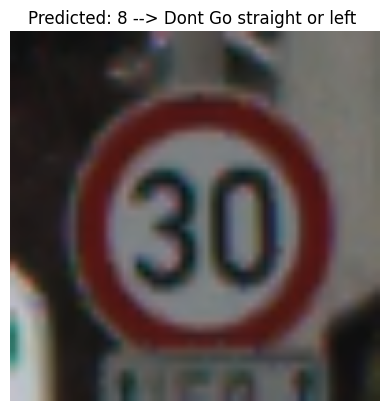

In [27]:
# Orginal image prediction 
traffic_prediction(random_image)

# Testing for translation invariance

In [28]:
# Translate the image 
def translate_image(image, tx, ty):
    # Converting into tensorflow tensor
    image = tf.convert_to_tensor(image, dtype = tf.float32)
    # Add batch dimension
    image = tf.expand_dims(image, axis = 0)
    # Get the orginal image size 
    img_height, img_width = 224,224
    # Padding to shift image in opposite direction
    padding_image = tf.image.pad_to_bounding_box(image, max(ty, 0),max(tx,0),img_height + abs(ty), img_width + abs(tx))
    # Cropping back to original size
    translated_image = tf.image.crop_to_bounding_box(padding_image, max(-ty, 0), max(-tx, 0), img_height, img_width)
    return tf.squeeze(translated_image)
    

In [29]:
# Apply translations to the image
shift_right = translate_image(random_image, tx=60, ty=0)  # Shift 30 pixels right
shift_left = translate_image(random_image, tx=-60, ty=0)  # Shift 30 pixels left
shift_up = translate_image(random_image, tx=0, ty=-60)  # Shift 30 pixels up
shift_down = translate_image(random_image, tx=0, ty=60)  # Shift 30 pixels down

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


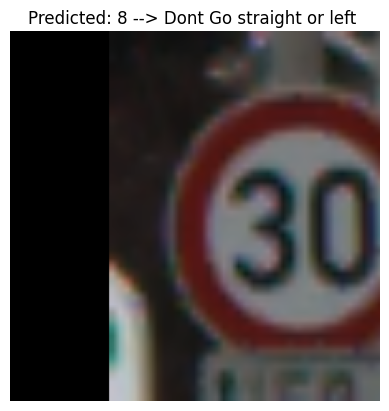

--------Orginal image shifted to right------


In [30]:
# Prediction for translated image 
traffic_prediction(shift_right)
print(f'--------Orginal image shifted to right------')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


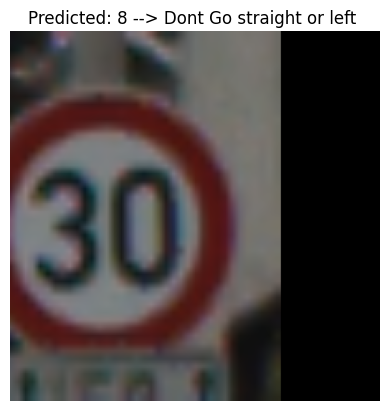

--------Orginal image shifted to left------


In [31]:
# Prediction for translated image 
traffic_prediction(shift_left)
print(f'--------Orginal image shifted to left------')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


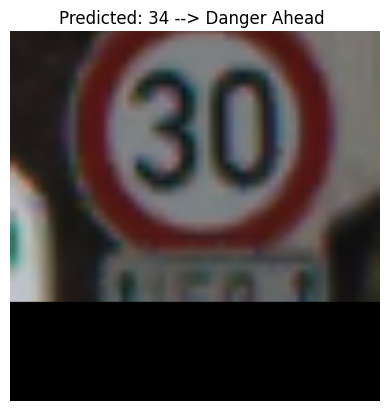

--------Orginal image shifted to up------


In [32]:
# Prediction for translated image 
traffic_prediction(shift_up)
print(f'--------Orginal image shifted to up------')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


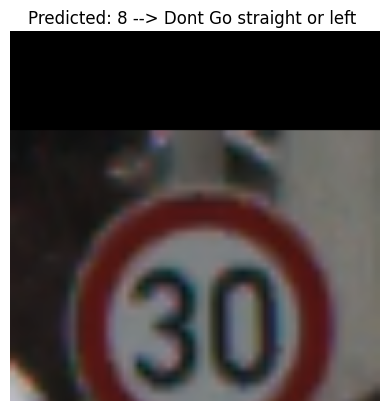

--------Orginal image shifted to down------


In [33]:
# Prediction for translated image 
traffic_prediction(shift_down)
print(f'--------Orginal image shifted to down------')

# Checking for the overfitting or underfitting

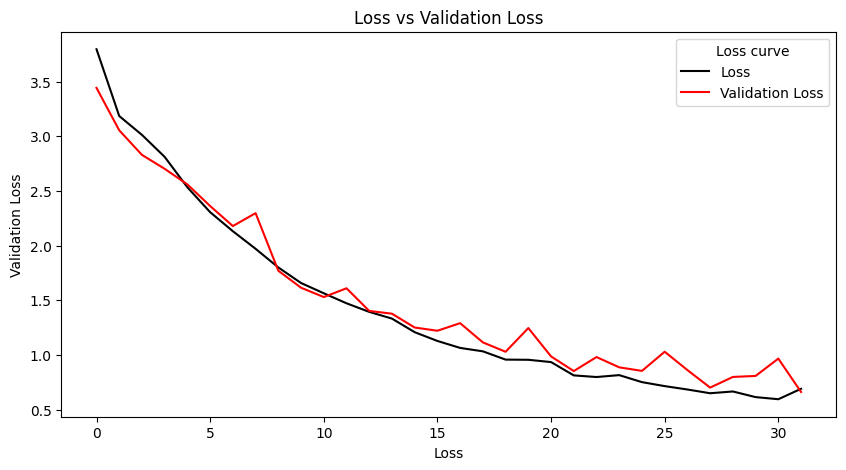

In [34]:
# Compare loss and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (10,5))
plt.plot(loss, color = 'black', label = 'Loss')
plt.plot(val_loss, color = 'red', label = 'Validation Loss')
plt.xlabel('Loss')
plt.ylabel('Validation Loss')
plt.legend(title = 'Loss curve')
plt.title('Loss vs Validation Loss')
plt.show()

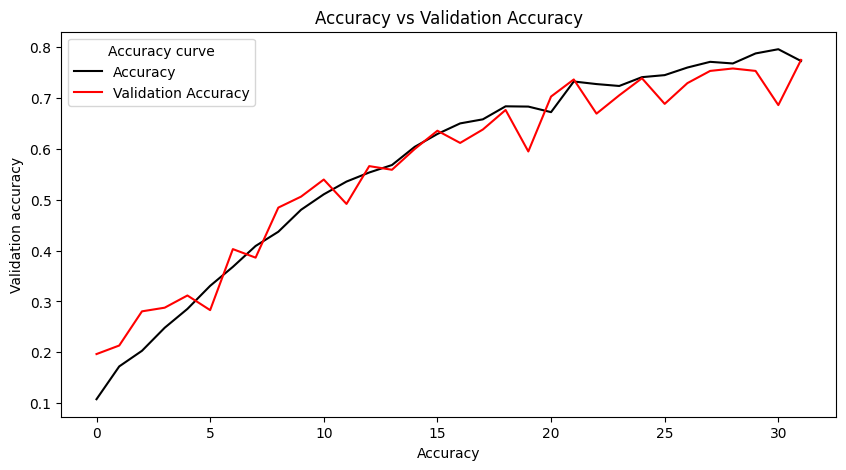

In [35]:
# Compare accuracy and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize = (10,5))
plt.plot(accuracy, color = 'black', label = 'Accuracy')
plt.plot(val_accuracy, color = 'red', label = 'Validation Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Validation accuracy')
plt.legend(title = 'Accuracy curve')
plt.title('Accuracy vs Validation Accuracy')
plt.show()